Binary classification CNN using the fast.ai library. 

Using v2 dataset. 80/20 split, no separate test. Time-based split.

Adding some data augmentations here - the ones that make sense.

In [1]:
from random import random
from pathlib import Path

# import * appears to be the fast.ai way of doing things,
# even though every instinct in me says "don't do this" :)
from fastai.vision import *  
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

In [2]:
MODEL_NAME = "model-fastai-time-with-tfms-less"

In [3]:
path = Path("~/data/split-v2-time").expanduser()

In [4]:
tfms = get_transforms(max_rotate=0, do_flip=False, max_zoom=1.05, max_warp=0, p_affine=0)
# tfms = [tfms[0][1], tfms[0][2]]
tfms

([RandTransform(tfm=TfmCrop (crop_pad), kwargs={'row_pct': (0, 1), 'col_pct': (0, 1), 'padding_mode': 'reflection'}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmAffine (zoom), kwargs={'scale': (1.0, 1.05), 'row_pct': (0, 1), 'col_pct': (0, 1)}, p=0, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (brightness), kwargs={'change': (0.4, 0.6)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True),
  RandTransform(tfm=TfmLighting (contrast), kwargs={'scale': (0.8, 1.25)}, p=0.75, resolved={}, do_run=True, is_random=True, use_on_y=True)],
 [RandTransform(tfm=TfmCrop (crop_pad), kwargs={}, p=1.0, resolved={}, do_run=True, is_random=True, use_on_y=True)])

In [57]:
def get_ex(): return open_image(random.choice(list((path / "train/BirdHome").glob("*.jpeg"))))

def plots_f(rows, cols, width, height, **kwargs):
    ex = get_ex()
    [ex.apply_tfms(tfms[0], **kwargs).show(ax=ax) for i,ax in enumerate(plt.subplots(
        rows,cols,figsize=(width,height))[1].flatten())]

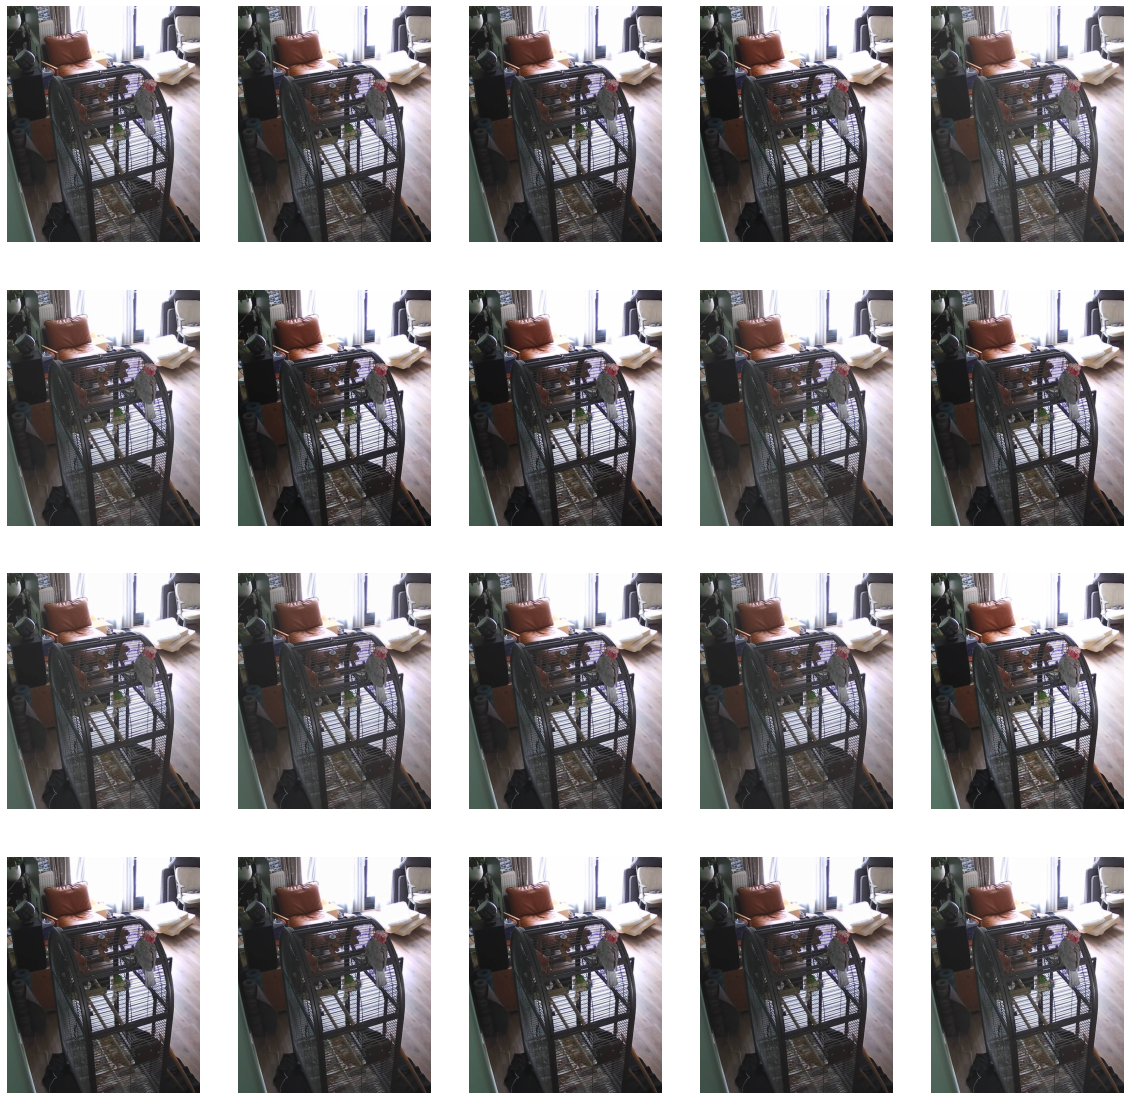

In [58]:
plots_f(4, 5, 20, 20)

In [5]:
data = ImageDataBunch.from_folder(path, bs=32, ds_tfms=tfms)

It seems to be already normalized (check with `data.one_batch(DatasetType.Train)`)

This loads a model with pretrained weights (imagenet?), custom head, everything is frozen apart from the head.

In [6]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy, ps=.6)

Dropout control with `ps`, default is .5.
I think it is like keras: the probability to zero out inputs.

In [ ]:
learn.lr_find()

In [ ]:
learn.recorder.plot()

In [61]:
learn.fit_one_cycle(2, 0.02)

epoch,train_loss,valid_loss,accuracy,time
0,0.398326,1.299350,0.844651,11:16
1,0.115364,0.125220,0.951163,13:02


In [62]:
learn.save(f"{MODEL_NAME}-02epoch")

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


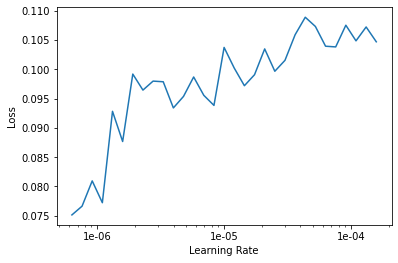

In [63]:
learn.unfreeze()
learn.data.batch_size = 28
learn.lr_find()
learn.recorder.plot()

That doesn't look too great. Let's stubbornly try with somewhat high LRs. (Can always revert...)

### CONTINUE FROM EPOCH 2, UNFREEZE, TRY WITH HEAD_LR 1e-4

In [64]:
head_lr = 1e-4
learn.fit_one_cycle(2, max_lr=[head_lr/100, head_lr/10, head_lr])

epoch,train_loss,valid_loss,accuracy,time
0,0.078283,0.085403,0.972093,14:03
1,0.062379,0.091898,0.967907,13:59


See if we can squeeze out a tiny bit more...

In [65]:
head_lr = 1e-6
learn.fit_one_cycle(1, max_lr=[head_lr/100, head_lr/10, head_lr])

epoch,train_loss,valid_loss,accuracy,time
0,0.066470,0.091109,0.969302,13:58


Nope. Well, it did in fact improve a bit with max head lr = 1e-4, even though LR plot suggested otherwise.

---
### RESTART FROM EPOCH 2, KEEP FROZEN, LR 1e-3

In [7]:
learn.load(f"{MODEL_NAME}-02epoch");
learn.freeze()  # Just in case
learn.data.batch_size = 28  # Not sure why this is needed now.
learn.fit_one_cycle(2, max_lr=1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.097911,0.085165,0.970233,10:27
1,0.078230,0.073971,0.971628,10:14


In [9]:
learn.save(f"{MODEL_NAME}-02epoch-plus02epochlrdiv10");

In [10]:
learn.unfreeze()

In [11]:
head_lr = 1e-4
learn.fit_one_cycle(2, max_lr=[head_lr/100, head_lr/10, head_lr])

epoch,train_loss,valid_loss,accuracy,time
0,0.068844,0.067227,0.977674,13:53
1,0.051212,0.063163,0.976279,13:50


In [12]:
learn.save(f"{MODEL_NAME}-02epoch-plus02epochlrdiv10-plus02epoch-unfrozen-lrdiv10");

In [13]:
learn.fit_one_cycle(2, max_lr=[head_lr/100, head_lr/10, head_lr])

epoch,train_loss,valid_loss,accuracy,time
0,0.046030,0.063687,0.973488,13:51
1,0.036382,0.058414,0.977209,13:52


In [15]:
learn.save(f"{MODEL_NAME}-02epoch-plus02epochlrdiv10-plus04epoch-unfrozen-lrdiv10");

Train loss keeps improving, valid loss as well. Haven't seen .05x yet. Keep on going for a bit longer:

In [16]:
learn.fit_one_cycle(2, max_lr=[head_lr/100, head_lr/10, head_lr])

epoch,train_loss,valid_loss,accuracy,time
0,0.031950,0.080542,0.967907,13:51
1,0.026841,0.056385,0.980465,13:51


Oh nice!

In [17]:
learn.save(f"{MODEL_NAME}-02epoch-plus02epochlrdiv10-plus06epoch-unfrozen-lrdiv10");

In [18]:
learn.fit_one_cycle(2, max_lr=[head_lr/100, head_lr/10, head_lr])

epoch,train_loss,valid_loss,accuracy,time
0,0.033262,0.072917,0.974419,13:51
1,0.016802,0.050703,0.980465,13:52


In [19]:
learn.save(f"{MODEL_NAME}-02epoch-plus02epochlrdiv10-plus08epoch-unfrozen-lrdiv10");

In [24]:
head_lr = 3e-5
learn.fit_one_cycle(1, max_lr=[head_lr/4, head_lr/2, head_lr])

epoch,train_loss,valid_loss,accuracy,time
0,0.023540,0.041910,0.983721,14:53


In [25]:
learn.save(f"{MODEL_NAME}-02epoch-plus02epochlrdiv10-plus08epoch-unfrozen-lrdiv10-plus01epoch-lrdiv10");

To sum up:
- Resnet18, transfer learn with frozen backbone, dropout .6
- Train 1cycle, 2 epochs @ max LR 1e-2
- Train 1cycle, 2 epochs @ max LR 1e-3
- Unfreeze
- Train 1cycle, 8 epochs @ max head LR 1e-4, middle head LR/10, base head LR/100.
- Train 1cycle, 1 epochs @ max head LR 1e-5, middle head LR/10, base head LR/100.

### Evaluate

In [26]:
pred_train = learn.get_preds(ds_type=DatasetType.Train)

In [27]:
accuracy(*pred_train)

tensor(0.9970)

In [28]:
pred_cv = learn.get_preds(ds_type=DatasetType.Valid)

In [29]:
accuracy(*pred_cv)

tensor(0.9837)

In [30]:
np.unique(pred_train[1], return_counts=True)

(array([0, 1]), array([7236, 1360]))

In [31]:
def sklearn_metrics(preds_output):
    preds, labels = preds_output
    pred_classes = (preds > .5).numpy().astype(int)[:, 1]
    
    acc = accuracy_score(labels, pred_classes)
    prec = precision_score(labels, pred_classes)
    recall = recall_score(labels, pred_classes)
    f1 = 2 * prec * recall / (prec + recall)

    print(f"Accuracy:  {acc:.3f}")  # Sanity check
    print(f"Precision: {prec:.3f}")
    print(f"Recall:    {recall:.3f}")
    print(f"F1:        {f1:.3f}")

In [32]:
sklearn_metrics(pred_train)

Accuracy:  0.997
Precision: 0.993
Recall:    0.988
F1:        0.990


In [33]:
sklearn_metrics(pred_cv)

Accuracy:  0.984
Precision: 0.925
Recall:    0.976
F1:        0.950


Low-ish precision means that we are getting false positives while predicting BirdRoaming. A bit less than 1 in 10.
So sometimes we think the bird is roaming, while it's actually still there. Would be nice to get this a bit higher, but it's already pretty good right now.

I think it might be good enough for a real-life deployment, given that we can average the prediction signal over time.

Quickly try test-time augumentation:

In [34]:
pred_cv_tta = Learner.TTA(learn)

In [35]:
accuracy(*pred_cv_tta)

tensor(0.8777)

Less! Ok, that's quite strange. There might be one or more augmentations that don't work very well at all. Well, no matter, it works quite well on the default image. Might want to investigate this further at some point.